(sec:correlation)=
# Electron correlation

The electron correlation describes instantaneous interaction between electrons in a molecular system. This interaction manifests itself as a relationship between [one- and two-electron densities](sec:reduced_densities) 

$$
n(\mathbf{r}, \mathbf{r}') \neq n(\mathbf{r}) n(\mathbf{r}')
$$

where $n(\mathbf{r}, \mathbf{r}')$ is the two-electron density. If the molecular system is described by an approximate wave function model that does not capture this instantaneous electron interaction, then the relationship between densities (incorrectly) becomes 

$$
n(\mathbf{r}, \mathbf{r}') = n(\mathbf{r}) n(\mathbf{r}')
$$

indicating completely independent motions of electrons in the molecular system.

## Correlation energy

Electron correlation arises from two primary sources namely the fermionic nature of electrons and the interaction between electrons. From the perspective of the Hartree–Fock method the first but not the second source is accounted for, and as a measure of this discrepancy the correlation energy is defined as

$$
E_{\textrm{corr}} = E_{\textrm{exact}} - E_{\textrm{HF}} 
$$

In work with approximate methods such as the plethora of wave function models, it is convenient to introduce a method specific correlation energy following Löwdin {cite:p}`Lowdin1980`

$$
E_{\textrm{corr}} = E_{\textrm{WF}} - E_{\textrm{HF}}  
$$

where $E_{\textrm{WF}}$ is the energy of the molecular system computed by the selected wave function model.

To illustrate these concepts, we will use the configuration interaction (CI) method to study the H$_2$ molecule. The obtained results provide the exact correlation energy within the chosen basis set.

In [42]:
import veloxchem as vlx
import multipsi as mtp
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision = 6, suppress = True, linewidth = 170)

mol_str = """
H     0.000000    0.000000   -0.70
H     0.000000    0.000000    0.70
"""
molecule = vlx.Molecule.read_str(mol_str, units='au')
basis = vlx.MolecularBasis.read(molecule, 'sto-3g')

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

hf_energy = scf_drv.get_scf_energy()

space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.FCI()

ci_drv = mtp.CIDriver()
ci_drv.compute(molecule, basis, space)

ci_energy = ci_drv.getEnergy(0)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

The correlation energy is small compared to the absolute energy.

In [43]:
print(f"HF energy: {hf_energy : .8f}")
print(f"CI energy: {ci_energy : .8f}")
print(f"Correlation energy: {ci_energy - hf_energy : .8f}")

HF energy: -1.11671433
CI energy: -1.13727594
Correlation energy: -0.02056162


## Visualizing electron correlation

### One-particle density

With access to both the Hartree–Fock and CI wave functions, we can investigate the densities using the `VisualizationDriver` class in Veloxchem.

This module gives us access to the orbital values at specified coordinates.

In [44]:
vis_drv = vlx.VisualizationDriver()

In [45]:
def get_orbs(coords, molecule, basis, mol_orbs):

    orbital_values = []

    norb = basis.get_dimensions_of_basis(molecule)
    for i in range(norb):
        
        values = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, i, 'alpha'))
        orbital_values.append(values)
        
    return orbital_values

The one-particle density equals the product of the density matrix and orbital densities.

For HF in the MO basis, the density matrix is diagonal with elements 2 and 0 for occupied and unoccupied orbitals, respectively. For CI, it is a bit more complicated, but the density matrix is provided by the CI driver.

In [50]:
def get_n1(orbital_values, ci_onepart_denmat):

    # One-particle densities for HF and CI
    
    n1_HF = 2 * orbital_values[0]**2 # first orbital is occupied
    
    n = len(orbital_values[0]) # number of points with orbital values
    norb = len(orbital_values) # number of orbitals

    n1_CI = np.zeros(n)
    
    for i in range(norb):
        for j in range(norb):
            
            n1_CI += ci_onepart_denmat[i,j] * orbital_values[i] * orbital_values[j]

    return n1_HF, n1_CI

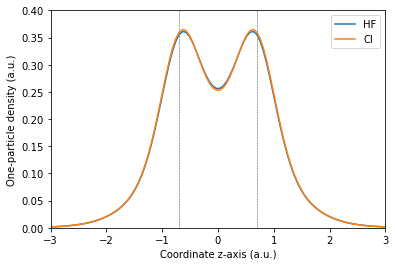

In [51]:
n = 100
coords = np.zeros((n,3))
coords[:,2] = np.linspace(-3, 3, n, endpoint=True)

orbital_values = get_orbs(coords, molecule, basis, scf_drv.mol_orbs)

n1_HF, n1_CI = get_n1(orbital_values, ci_drv.get1den(0))

plt.plot(coords[:,2], n1_HF, label = 'HF')
plt.plot(coords[:,2], n1_CI, label = 'CI')
plt.legend()

plt.axvline(x = 0.70, color = '0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.axvline(x = -0.70, color = '0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-3,3), ylim = (0,0.4))

plt.ylabel('One-particle density (a.u.)')
plt.xlabel('Coordinate z-axis (a.u.)')

plt.show()

The differences one-particle densities at the HF and CI levels of theory are very minor. Upon close inspection of the CI density, it is possible to discern a small decrease in the middle of the bond, compensated for by a minor increase around the nuclei. 

### Two-particle density

Given the nature of electron correlation, it is in the two-particle density that approximate method shortcomings are expected to more clearly reveal themselves. 

In [52]:
def get_n12(orbital_values_1, orbital_values_2, ci_twopart_denmat):
    
    # Two-particle densities for HF and CI

    n12_HF = 2 * orbital_values_1[0]**2 * orbital_values_2[0]**2
    
    n = len(orbital_values_2[0]) # number of points with orbital values
    norb = len(orbital_values_2) # number of orbitals

    n12_CI = np.zeros(n)
    
    for i in range(norb):
        for j in range(norb):
            for k in range(norb):
                for l in range(norb):

                    n12_CI += (ci_twopart_denmat[i,j,k,l] * 
                               orbital_values_1[i] * orbital_values_1[j] * 
                               orbital_values_2[k] * orbital_values_2[l])

    return n12_HF, n12_CI

Let us determine the probability density for finding one electron at the position of the hydrogen nucleus and the other at any point on the internuclear axis.

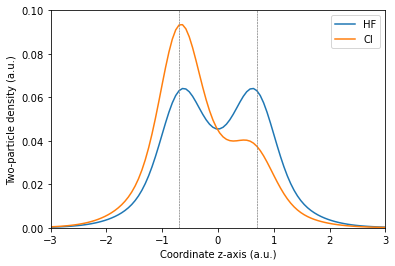

In [53]:
# electron 1 at the position of the hydrogen nucleus
# electron 2 anywhere on the internuclear axis
orbital_values_1 = get_orbs([[0, 0, 0.70]], molecule, basis, scf_drv.mol_orbs)
orbital_values_2 = get_orbs(coords, molecule, basis, scf_drv.mol_orbs)

n12_HF, n12_CI = get_n12(orbital_values_1, orbital_values_2, ci_drv.get2den(0))

plt.plot(coords[:,2], n12_HF, label = 'HF')
plt.plot(coords[:,2], n12_CI, label = 'CI')

plt.legend()

plt.axvline(x = 0.70, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.axvline(x = -0.70, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-3,3), ylim = (0,0.1))

plt.ylabel('Two-particle density (a.u.)')
plt.xlabel('Coordinate z-axis (a.u.)')

plt.show()

It is here clearly shown how the HF wave functions fails to describe the asymmetry in the two-particle density. As correctly captured by the CI wave function, the probability for finding both electrons at the position of the same (right-most) hydrogen nucleus should be smaller than to find the electrons positioned at different nuclei.

### Electron cusp and basis set convergence

As immediately seen in Slater type orbitals, the point charge model of atomic nuclei creates a cusp in the electronic wave function, *i.e.*, a discontinuity in its derivative.

Likewise, the point charge of an electron at a given position in space should create a cusp in the wave function relating it to any other electrons. As standard quantum chemistry methods does not introduce any explicit dependence on the interelectronic distances, it is expected that this electron–electron cusp display a slow convergence. 

As an illustration of this fact, let us study the helium atom with one electron fixed in space and the other one positioned on a circle such that their positions coincide at one point.

In [56]:
molecule = vlx.Molecule.read_str("He  0.0 0.0 0.0")

theta = np.linspace(-np.pi, np.pi, n, endpoint=True)
coords = np.zeros((n,3))
coords[:,0] = 0.70 * np.cos(theta)
coords[:,1] = 0.70 * np.sin(theta)

# one- and two-particle densities for each basis set in lists
n1_HF = []
n12_HF = []
n12_CI = []

for basis_set in ['sto-3g', 'cc-pvdz', 'cc-pvtz']:

    basis = vlx.MolecularBasis.read(molecule, basis_set)
    scf_drv.compute(molecule, basis)
    
    space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
    space.FCI()

    ci_drv = mtp.CIDriver()
    ci_drv.compute(molecule, basis, space)

    orbital_values_1 = get_orbs([[0.70, 0, 0]], molecule, basis, scf_drv.mol_orbs)
    orbital_values_2 = get_orbs(coords, molecule, basis, scf_drv.mol_orbs)
   
    den_HF, den_CI = get_n12(orbital_values_1, orbital_values_2, ci_drv.get2den(0))
    
    n12_HF.append(den_HF)
    n12_CI.append(den_CI)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

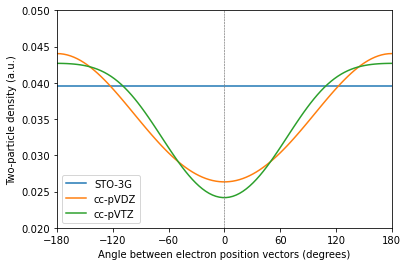

In [64]:
plt.plot(theta * 180 / np.pi, n12_CI[0], label='STO-3G')
plt.plot(theta * 180 / np.pi, n12_CI[1], label='cc-pVDZ')
plt.plot(theta * 180 / np.pi, n12_CI[2], label='cc-pVTZ')
plt.legend()

plt.axvline(x = 0, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-180,180), ylim = (0.02,0.05), xticks = range(-180,190,60))

plt.ylabel('Two-particle density (a.u.)')
plt.xlabel('Angle between electron position vectors (degrees)')

plt.show()

The basis set effect is seen to be large. With STO-3G, a minimal basis, there are no virtual orbitals and therefore no correlation.

With increased basis set quality, the cusp gets sharper. But convergence is slow. This illustrates why correlated wave function methods require large and flexible basis sets to converge. For HF and DFT, in contrast, the basis set only needs to accommodate an accurate description of the one-particle density and convergence is therefore much faster.